# Notebook to identify number of other OPRM1-interacting drugs use vs total exposures to morphine/codeine

## Obtain eids and start and end era per drug

Using omop drug era database

In [ ]:
import pyspark
import dxpy
import dxdata
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Import to current directory:
- mappings/drug_era/drug_era_atc.tsv
- src/project_permed

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_ATC = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_ATC = filtered_df_ATC[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_ATC.rename(columns={"_c13": "ATC"}, inplace=True)

display(filtered_df_ATC)

The following drugs were not found in the dataset: 3-methylthiofentanyl, hydrocodone, levallorphan, opium, pentoxyverine, tianeptine, butyrfentanyl, morphine glucuronide, dimethylthiambutene, 3-methylfentanyl, alvimopan, dezocine, diprenorphine, anileridine, epicept np-1, naldemedine, v1003, diamorphine, sufentanil, trimebutine, remifentanil, samidorphan, carfentanil, eluxadoline, ketobemidone, oliceridine, metenkefalin, loxicodegol, butorphanol, dihydromorphine, levacetylmethadol, nabiximols, ethylmorphine, etorphine, nalbuphine, cannabis, dextropropoxyphene, li-301, levorphanol, methadyl acetate, methylnaltrexone, oxymorphone


,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03


In [4]:
# Import the ATC dictionaries from atc_dict.py
from atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_ATC["ATC_First_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_ATC["ATC_Second_Level"] = filtered_df_ATC["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_ATC["First_Level_Name"] = filtered_df_ATC["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_ATC["Second_Level_Name"] = filtered_df_ATC["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_ATC

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12,N,N05,Nervous System,Psycholeptics
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03,A,A06,Alimentary Tract and Metabolism,Drugs for Constipation
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09,N,N06,Nervous System,Psychoanaleptics
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03,N,N01,Nervous System,Anesthetics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."


In [5]:
# Save the filtered table to a new file
filtered_df_ATC.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [6]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [7]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' table
omop_drug_era = "omop_drug_era"

# Load table
drug_era = dataset[omop_drug_era]

# Extract all field names from the table
field_names_era = [f.name for f in drug_era.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())

print(df_era.columns)

print(f"Number of entries era {df_era.count()}")
df_era.drop("eid").show(3, truncate=False)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
Number of entries era 19959413
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|1236950609195|19005129       |12/05/2014         |10/06/2014       |1                  |0       |
|798863919105 |743670         |30/03/2011         |02/09/2011       |5                  |12      |
|721554547993 |19008994       |12/10/2010         |07/11/2010       |1                  |0       |
+-------------+---------------+-------------------+-----------------+-------------------+--------+
only showing top 3 rows



In [8]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [ ]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(F.col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", F.to_date(F.col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", F.to_date(F.col("drug_era_end_date"), "dd/MM/yyyy"))

# Remove duplicates in drug_mapping_df based on 'drug_concept_id' and 'concept_name'
drug_mapping_df = drug_mapping_df.drop_duplicates(
    subset=["drug_concept_id", "concept_name"]
)

# Convert Pandas DataFrame (drug_mapping_df) to Spark DataFrame
drug_mapping_spark_df = spark.createDataFrame(drug_mapping_df)

# Ensure "drug_concept_id" is the same type in both DataFrames
filtered_df_era = filtered_df_era.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)
drug_mapping_spark_df = drug_mapping_spark_df.withColumn(
    "drug_concept_id", F.col("drug_concept_id").cast("int")
)

# Perform the join with drug_mapping_df on "drug_concept_id"
filtered_df_era = filtered_df_era.join(
    drug_mapping_spark_df.select(
        "drug_concept_id", "concept_name"
    ),  # Select only necessary columns
    on="drug_concept_id",
    how="left",
)

# Rename the 'concept_name' column to 'drug'
filtered_df_era = filtered_df_era.withColumnRenamed("concept_name", "drug")

# Sort by "drug_era_start_date"
filtered_df_era = filtered_df_era.orderBy("drug_era_start_date")

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|drug_concept_id|drug_era_id  |drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug         |
+---------------+-------------+-------------------+-----------------+-------------------+--------+-------------+
|991876         |652835088928 |1990-01-01         |1990-01-30       |1                  |0       |loperamide   |
|1201620        |1597727924666|1990-01-01         |1990-01-30       |1                  |0       |codeine      |
|991876         |1486058743225|1990-01-01         |1990-01-06       |1                  |0       |loperamide   |
|991876         |1314260071294|1990-01-01         |1990-01-12       |1                  |0       |loperamide   |
|1201620        |601295454371 |1990-01-02         |1990-01-31       |1                  |0       |codeine      |
|1201620        |1262720440376|1990-01-02         |1990-01-31       |1                  |0      

869262

In [10]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_filtered_df_era = filtered_df_era.toPandas()

In [ ]:
# Filter for rows with "morphine" or "codeine" in the "drug" column (case-insensitive)
filtered_df_era_morphine_codeine = pandas_filtered_df_era[
    pandas_filtered_df_era["drug"].str.contains(
        "morphine|codeine", case=False, na=False
    )
]

# Show the result of the filter
display(filtered_df_era_morphine_codeine.drop("eid", axis=1))

,drug_concept_id,drug_era_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,drug
0,1201620,1597727924666,1990-01-01,1990-01-30,1,0,codeine
4,1201620,601295454371,1990-01-02,1990-01-31,1,0,codeine
5,1201620,1262720440376,1990-01-02,1990-01-31,1,0,codeine
6,1201620,128849029717,1990-01-03,1990-02-01,1,0,codeine
7,1201620,1434519131532,1990-01-03,1990-02-01,1,0,codeine
...,...,...,...,...,...,...,...
869249,1201620,558345805315,2017-09-20,2017-10-19,1,0,codeine
869250,1201620,601295449619,2017-09-20,2017-10-19,1,0,codeine
869251,1201620,781684096456,2017-09-20,2017-10-19,1,0,codeine
869252,1201620,128849082881,2017-09-20,2017-10-19,1,0,codeine


In [ ]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
filtered_df_era_morphine_codeine_grouped = (
    filtered_df_era_morphine_codeine.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        drugs=("drug", list),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(filtered_df_era_morphine_codeine_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0]
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]"
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]"
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]"
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]"
...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]"
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]"
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]"


In [ ]:
pandas_filtered_df_era_drugs = (
    pandas_filtered_df_era.groupby("eid").agg(drugs=("drug", list)).reset_index()
)
display(pandas_filtered_df_era_drugs.drop("eid", axis=1))
# Extract the unique EIDs from the the codeine and morphine df
eids_to_keep = filtered_df_era_morphine_codeine_grouped["eid"].unique()

# Filter the rows in pandas_filtered_df_era based on the extracted EIDs
pandas_filtered_df_era_drugs = pandas_filtered_df_era_drugs[
    pandas_filtered_df_era_drugs["eid"].isin(eids_to_keep)
]

# Display the filtered DataFrame
display(pandas_filtered_df_era_drugs.drop("eid", axis=1))

,drugs
0,"[tramadol, tramadol, amitriptyline, amitriptyl..."
1,[diphenoxylate]
2,[codeine]
3,"[pholcodine, pholcodine]"
4,"[codeine, codeine]"
...,...
124542,"[tramadol, tramadol, codeine, codeine, codeine..."
124543,"[codeine, codeine, codeine, codeine, codeine]"
124544,[tramadol]
124545,"[codeine, codeine, pholcodine, amitriptyline, ..."


,drugs
2,[codeine]
4,"[codeine, codeine]"
5,"[codeine, amitriptyline, tramadol, codeine, co..."
6,"[pholcodine, codeine, codeine, codeine, codein..."
7,"[codeine, codeine, codeine]"
...,...
124541,"[codeine, codeine, codeine, codeine, codeine, ..."
124542,"[tramadol, tramadol, codeine, codeine, codeine..."
124543,"[codeine, codeine, codeine, codeine, codeine]"
124545,"[codeine, codeine, pholcodine, amitriptyline, ..."


In [ ]:
# Define the set of target drugs (morphine and codeine)
target_drugs = {"morphine", "codeine"}

# Calculate the number of unique drugs excluding morphine and codeine
pandas_filtered_df_era_drugs["num_other_drugs"] = pandas_filtered_df_era_drugs[
    "drugs"
].apply(lambda drug_list: len(set(drug_list) - target_drugs))

# Display the updated DataFrame
print(pandas_filtered_df_era_drugs.drop("eid", axis=1))

                                                    drugs  num_other_drugs
2                                               [codeine]                0
4                                      [codeine, codeine]                0
5       [codeine, amitriptyline, tramadol, codeine, co...                2
6       [pholcodine, codeine, codeine, codeine, codein...                1
7                             [codeine, codeine, codeine]                0
...                                                   ...              ...
124541  [codeine, codeine, codeine, codeine, codeine, ...                3
124542  [tramadol, tramadol, codeine, codeine, codeine...                1
124543      [codeine, codeine, codeine, codeine, codeine]                0
124545  [codeine, codeine, pholcodine, amitriptyline, ...                3
124546                                          [codeine]                0

[103449 rows x 2 columns]


In [ ]:
# Total exposures per participant
# Convert all elements in 'exposure_counts' lists to integers
filtered_df_era_morphine_codeine_grouped["exposure_counts"] = (
    filtered_df_era_morphine_codeine_grouped["exposure_counts"].apply(
        lambda x: [int(i) for i in x]  # Ensures all elements are integers
    )
)

# Compute total_exposure_counts
filtered_df_era_morphine_codeine_grouped["total_exposure_counts"] = (
    filtered_df_era_morphine_codeine_grouped["exposure_counts"].apply(sum)
)

# Number of days medication is available (drug era duration - gap days)
# Convert string dates to datetime format
filtered_df_era_morphine_codeine_grouped["start_dates_parsed"] = (
    filtered_df_era_morphine_codeine_grouped[
        "start_dates"
    ].apply(lambda x: pd.to_datetime(x))
)
filtered_df_era_morphine_codeine_grouped["end_dates_parsed"] = (
    filtered_df_era_morphine_codeine_grouped[
        "end_dates"
    ].apply(lambda x: pd.to_datetime(x))
)
filtered_df_era_morphine_codeine_grouped["gap_days"] = (
    filtered_df_era_morphine_codeine_grouped["gap_days"].apply(
        lambda x: [int(i) for i in x]  # Ensures all elements are integers
    )
)


# Function to calculate available medication days accounting for overlaps
def calculate_available_days(row):
    start_dates = row["start_dates_parsed"]
    end_dates = row["end_dates_parsed"]
    gap_days = row["gap_days"]

    intervals = sorted(zip(start_dates, end_dates, gap_days))

    total_days = 0
    last_end = None  # Track last end date for overlap detection

    for start, end, gap in intervals:
        duration = (end - start).days - gap

        if last_end is None or start > last_end:  # No overlap
            total_days += duration
        else:  # Overlap case
            overlap = (last_end - start).days
            effective_days = max(0, duration - overlap)  # Remove overlap
            total_days += effective_days

        last_end = max(last_end, end) if last_end else end  # Update last end date

    return total_days


# Apply function to each row
filtered_df_era_morphine_codeine_grouped["available_medication_days"] = (
    filtered_df_era_morphine_codeine_grouped.apply(calculate_available_days, axis=1)
)

# Merge the two DataFrames based on "eid"
filtered_df_era_morphine_codeine_grouped = filtered_df_era_morphine_codeine_grouped.merge(
    pandas_filtered_df_era_drugs[["eid", "num_other_drugs"]],
    on="eid",
    how="left",  # Use left join to retain all rows from filtered_df_era_morphine_codeine_grouped
)

In [16]:
display(filtered_df_era_morphine_codeine_grouped.drop("eid", axis=1))

,num_drug_era_id,drugs,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,start_dates_parsed,end_dates_parsed,available_medication_days,num_other_drugs
0,1,[codeine],[2004-12-20],[2004-12-28],[1],[0],1,"DatetimeIndex(['2004-12-20'], dtype='datetime6...","DatetimeIndex(['2004-12-28'], dtype='datetime6...",8,0
1,2,"[codeine, codeine]","[2012-05-24, 2013-03-22]","[2012-06-22, 2013-04-20]","[1, 1]","[0, 0]",2,"DatetimeIndex(['2012-05-24', '2013-03-22'], dt...","DatetimeIndex(['2012-06-22', '2013-04-20'], dt...",58,0
2,3,"[codeine, codeine, codeine]","[2011-05-18, 2011-09-27, 2013-06-27]","[2011-08-06, 2011-10-30, 2013-07-05]","[6, 1, 1]","[0, 0, 0]",8,"DatetimeIndex(['2011-05-18', '2011-09-27', '20...","DatetimeIndex(['2011-08-06', '2011-10-30', '20...",121,2
3,6,"[codeine, codeine, codeine, codeine, codeine, ...","[2008-06-03, 2008-09-18, 2008-12-23, 2009-03-1...","[2008-07-02, 2008-10-18, 2009-01-21, 2009-04-1...","[1, 2, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]",7,"DatetimeIndex(['2008-06-03', '2008-09-18', '20...","DatetimeIndex(['2008-07-02', '2008-10-18', '20...",175,1
4,3,"[codeine, codeine, codeine]","[2008-06-09, 2012-03-05, 2014-11-17]","[2008-06-13, 2012-04-03, 2014-12-16]","[1, 1, 1]","[0, 0, 0]",3,"DatetimeIndex(['2008-06-09', '2012-03-05', '20...","DatetimeIndex(['2008-06-13', '2012-04-03', '20...",62,0
...,...,...,...,...,...,...,...,...,...,...,...
103444,7,"[codeine, codeine, codeine, codeine, codeine, ...","[1999-04-01, 2001-12-07, 2002-12-11, 2010-01-2...","[1999-04-30, 2002-01-22, 2003-01-09, 2010-02-1...","[1, 2, 1, 1, 2, 1, 1]","[0, 0, 0, 0, 26, 0, 0]",9,"DatetimeIndex(['1999-04-01', '2001-12-07', '20...","DatetimeIndex(['1999-04-30', '2002-01-22', '20...",249,3
103445,10,"[codeine, codeine, codeine, codeine, codeine, ...","[2010-03-22, 2010-09-27, 2011-02-08, 2012-02-0...","[2010-07-17, 2010-10-26, 2011-06-17, 2012-03-0...","[4, 1, 3, 1, 1, 1, 1, 1, 1, 1]","[21, 0, 42, 0, 0, 0, 0, 0, 0, 0]",15,"DatetimeIndex(['2010-03-22', '2010-09-27', '20...","DatetimeIndex(['2010-07-17', '2010-10-26', '20...",415,1
103446,5,"[codeine, codeine, codeine, codeine, codeine]","[2000-06-06, 2006-01-10, 2006-05-16, 2011-06-2...","[2000-07-05, 2006-02-08, 2006-06-14, 2011-07-2...","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]",5,"DatetimeIndex(['2000-06-06', '2006-01-10', '20...","DatetimeIndex(['2000-07-05', '2006-02-08', '20...",145,0
103447,8,"[codeine, codeine, codeine, codeine, codeine, ...","[2001-08-13, 2005-04-25, 2008-07-25, 2009-03-0...","[2001-09-11, 2005-05-24, 2008-12-31, 2009-04-0...","[1, 1, 4, 1, 2, 11, 2, 1]","[0, 0, 46, 0, 24, 31, 12, 0]",23,"DatetimeIndex(['2001-08-13', '2005-04-25', '20...","DatetimeIndex(['2001-09-11', '2005-05-24', '20...",566,3


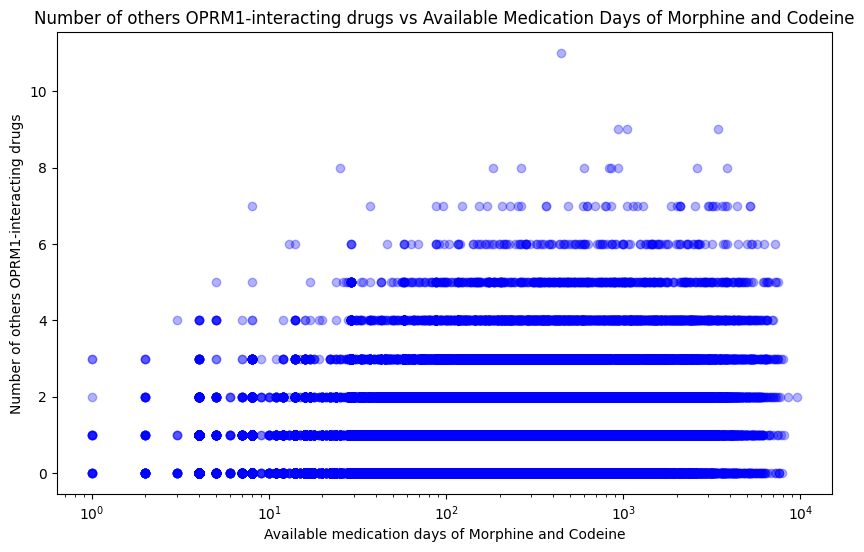

In [ ]:
# Scatter plot of 'num_other_drugs' vs 'available_medication_days'
plt.figure(figsize=(10, 6))
plt.scatter(
    filtered_df_era_morphine_codeine_grouped["available_medication_days"],
    filtered_df_era_morphine_codeine_grouped["num_other_drugs"],
    alpha=0.3,
    color="b",
)

# Set x-axis to logarithmic scale
plt.xscale("log")

# Add labels and title
plt.title(
    "Number of others OPRM1-interacting drugs vs Available Medication Days of Morphine and Codeine"
)
plt.xlabel("Available medication days of Morphine and Codeine")
plt.ylabel("Number of others OPRM1-interacting drugs")

# Show the plot
plt.show()

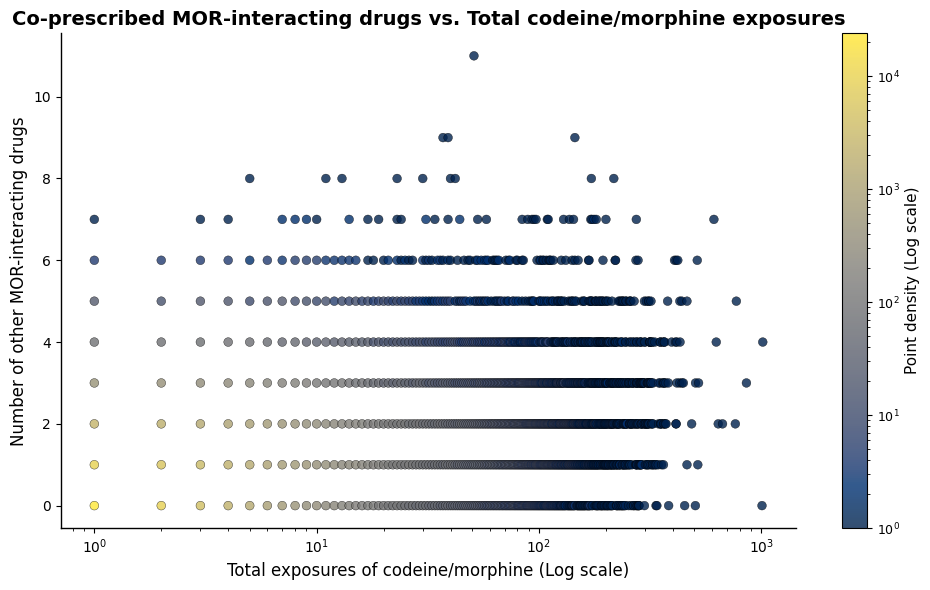

In [ ]:
# Group by pair and count
grouped = (
    filtered_df_era_morphine_codeine_grouped.groupby(
        ["total_exposure_counts", "num_other_drugs"]
    )
    .size()
    .reset_index(name="count")
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with log-normalized color scale
sc = ax.scatter(
    grouped["total_exposure_counts"],
    grouped["num_other_drugs"],
    c=grouped["count"],
    cmap="cividis",  # Good grayscale and print colormap
    norm=LogNorm(vmin=grouped["count"].min(), vmax=grouped["count"].max()),
    alpha=0.8,
    edgecolor="black",
    linewidth=0.3,
    s=40,  # Optional: increase point size for better visibility
)

# Log scale for x-axis
ax.set_xscale("log")

# Axis labels and title
ax.set_title(
    "Co-prescribed MOR-interacting drugs vs. Total codeine/morphine exposures",
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("Total exposures of codeine/morphine (Log scale)", fontsize=12)
ax.set_ylabel("Number of other MOR-interacting drugs", fontsize=12)

# Ticks and axis styling
ax.tick_params(axis="both", labelsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.grid(False)  # Clean thesis-ready look

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Point density (Log scale)", fontsize=11)
cbar.ax.tick_params(labelsize=9)

# Save figure
plt.tight_layout()
plt.savefig("scatter_exposures_vs_otherdrugs.png", dpi=300, bbox_inches="tight")
plt.show()